<a href="https://colab.research.google.com/github/mhjalili84/Federated-Learning/blob/main/FedBuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Federated Learning with Buffered Asynchronous Aggregation
Ref: https://arxiv.org/pdf/2106.06639


#Import libraries and settings

In [1]:
import argparse
import random
import time
import threading
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset

#Settings

In [2]:
# --------- Argument Parser ---------
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--num_clients', type=int, default=3, help='Number of clients')
    parser.add_argument('--alpha', type=float, default=0.1, help='Dirichlet distribution alpha')
    parser.add_argument('--epochs', type=int, default=20, help='Number of communication rounds')
    parser.add_argument('--batch_size', type=int, default=24, help='Batch size for local training')
    parser.add_argument('--local_epochs', type=int, default=5, help='Number of local epochs per client')
    parser.add_argument('--buffer_size', type=int, default=3, help='Number of updates to trigger aggregation')
    parser.add_argument('--delay_means', nargs='+', type=float, default=[0.5, 2.5, 1], help='Means of communication delay for each client')
    parser.add_argument('--delay_stds', nargs='+', type=float, default=[0.2, 0.2, 0.2], help='Standard deviations of communication delay for each client')
    args = parser.parse_args([])
    return args

args = parse_args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Load and split MNIST dataset

In [3]:
# --------- Data Loading and Partitioning ---------
def load_data_dirichlet(num_clients, alpha=0.5):
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

    labels = np.array(train_dataset.targets)
    num_classes = 10

    data_split = [[] for _ in range(num_clients)]

    for k in range(num_classes):
        idx_k = np.where(labels == k)[0]
        np.random.shuffle(idx_k)
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
        client_idx_split = np.split(idx_k, proportions)

        for i in range(num_clients):
            data_split[i].extend(client_idx_split[i])

    client_datasets = [Subset(train_dataset, indices) for indices in data_split]
    test_indices = list(range(len(test_dataset)))
    random.shuffle(test_indices)
    server_test_set = Subset(test_dataset, test_indices[:int(0.1 * len(test_dataset))])

    return client_datasets, server_test_set

client_datasets, server_test_dataset = load_data_dirichlet(num_clients=args.num_clients, alpha=args.alpha)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.12MB/s]


#Define model

In [4]:
# --------- MLP Model Definition ---------
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)

#Define training, evaluation and utility functions

In [5]:
# --------- Client Definition ---------
class Client:
    def __init__(self, id, train_dataset, delay_mean, delay_std):
        self.id = id
        self.train_dataset = train_dataset
        self.delay_mean = delay_mean
        self.delay_std = delay_std
        self.model = MLP().to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.005)

    def train(self, local_epochs, batch_size):
        loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        self.model.train()
        for epoch in range(local_epochs):
            for data, target in loader:
                data, target = data.to(device), target.to(device)
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()

    def get_parameters(self):
        return copy.deepcopy(self.model.state_dict())

    def set_parameters(self, new_params):
        self.model.load_state_dict(new_params)

    def client_update(self, local_epochs, batch_size):
        self.train(local_epochs, batch_size)
        delay = max(0, np.random.normal(self.delay_mean, self.delay_std))
        time.sleep(delay)
        return self.get_parameters(), len(self.train_dataset)

# --------- Server Definition ---------
class Server:
    def __init__(self, test_dataset):
        self.global_model = MLP().to(device)
        self.test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
        self.buffer_updates = []  # list of (delta, size)

    def test(self):
        self.global_model.eval()
        correct = 0
        total = 0
        total_loss = 0
        criterion = nn.CrossEntropyLoss()
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(device), target.to(device)
                outputs = self.global_model(data)
                loss = criterion(outputs, target).item()
                total_loss += loss
                preds = outputs.argmax(dim=1)
                correct += preds.eq(target).sum().item()
                total += target.size(0)
        accuracy = correct / total
        avg_loss = total_loss / len(self.test_loader)
        return avg_loss, accuracy

#Federated training loop

Communication round 1
Buffer full. Aggregating...
Round 1: Loss=1.5418, Accuracy=49.40%
Communication round 2
Buffer full. Aggregating...
Round 2: Loss=0.7770, Accuracy=72.90%
Communication round 3
Buffer full. Aggregating...
Round 3: Loss=0.5121, Accuracy=82.00%
Communication round 4
Buffer full. Aggregating...
Round 4: Loss=0.4320, Accuracy=85.00%
Communication round 5
Buffer full. Aggregating...
Round 5: Loss=0.3727, Accuracy=87.80%
Communication round 6
Buffer full. Aggregating...
Round 6: Loss=0.3393, Accuracy=89.30%
Communication round 7
Buffer full. Aggregating...
Round 7: Loss=0.3226, Accuracy=89.50%
Communication round 8
Buffer full. Aggregating...
Round 8: Loss=0.3107, Accuracy=89.80%
Communication round 9
Buffer full. Aggregating...
Round 9: Loss=0.2919, Accuracy=90.30%
Communication round 10
Buffer full. Aggregating...
Round 10: Loss=0.2790, Accuracy=90.50%
Communication round 11
Buffer full. Aggregating...
Round 11: Loss=0.2677, Accuracy=90.70%
Communication round 12
Buffe

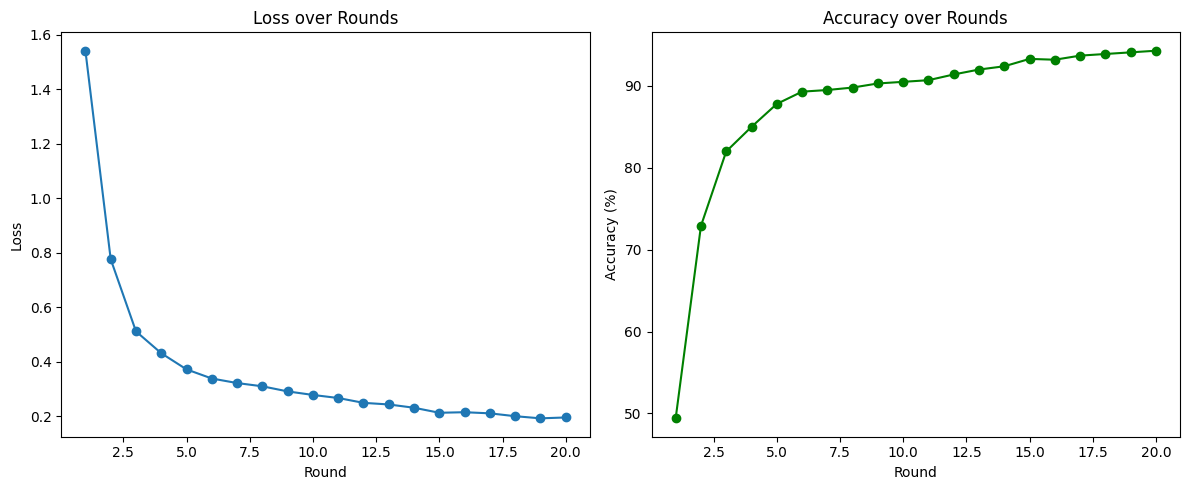

In [6]:
# --------- Federated Training Function (FedBuff + FedAvg-like) ---------
def federated_training():
    clients = [Client(i, client_datasets[i], args.delay_means[i], args.delay_stds[i]) for i in range(args.num_clients)]
    server = Server(server_test_dataset)
    losses = []
    accuracies = []
    lock = threading.Lock()
    eta_g = 1.0

    for epoch in range(args.epochs):
        print(f'Communication round {epoch+1}')

        def client_thread_func(i):
            current_params = server.global_model.state_dict()
            clients[i].set_parameters(current_params)
            new_params, data_size = clients[i].client_update(args.local_epochs, args.batch_size)
            delta = {k: current_params[k] - new_params[k] for k in current_params.keys()}

            with lock:
                server.buffer_updates.append((delta, data_size))
                if len(server.buffer_updates) >= args.buffer_size:
                    print("Buffer full. Aggregating...")
                    total_size = sum([size for _, size in server.buffer_updates])
                    agg_delta = {k: sum([d[k] * size / total_size for d, size in server.buffer_updates])
                                 for k in current_params.keys()}
                    new_state = {k: current_params[k] - eta_g * agg_delta[k] for k in current_params.keys()}
                    server.global_model.load_state_dict(new_state)
                    server.buffer_updates = []

        client_threads = []
        for i in range(args.num_clients):
            t = threading.Thread(target=client_thread_func, args=(i,))
            t.start()
            client_threads.append(t)

        for t in client_threads:
            t.join()

        loss, acc = server.test()
        losses.append(loss)
        accuracies.append(acc)
        print(f'Round {epoch+1}: Loss={loss:.4f}, Accuracy={acc*100:.2f}%')

    # Plot training curves
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, args.epochs+1), losses, marker='o')
    plt.title('Loss over Rounds')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(range(1, args.epochs+1), [acc*100 for acc in accuracies], marker='o', color='green')
    plt.title('Accuracy over Rounds')
    plt.xlabel('Round')
    plt.ylabel('Accuracy (%)')
    plt.tight_layout()
    plt.show()


# --------- Run Training ---------
if __name__ == "__main__":
    federated_training()